# Fussing with Healpix

In [53]:
# 
import os
import numpy as np
import healpy as hp
import pandas

from scipy import interpolate

import iris


In [23]:
%matplotlib notebook

In [3]:
noaa_path = '/home/xavier/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/'

# Load one

In [6]:
file_1990 = os.path.join(noaa_path, 'sst.day.mean.1990.nc')
cubes_1990 = iris.load(file_1990)
sst_1990 = cubes_1990[0]
sst_1990

<iris 'Cube' of Daily Sea Surface Temperature / (degC) (time: 365; latitude: 720; longitude: 1440)>

In [7]:
# Realize
_ = sst_1990.data

## Grab a day, any day

In [8]:
jan1_1990 = sst_1990.data[0,:,:]

In [9]:
jan1_1990.shape

(720, 1440)

## Coords

In [35]:
lat_coord = sst_1990.coord('latitude').points
lon_coord = sst_1990.coord('longitude').points

In [37]:
lat_coord[0:5]

array([-89.875, -89.625, -89.375, -89.125, -88.875], dtype=float32)

# Init Healpix

## nside

In [11]:
npix = np.product(jan1_1990.shape)
npix

1036800

In [14]:
nside_approx = np.sqrt(npix/12.)
nside_approx

293.9387691339814

In [15]:
nside = 294

In [22]:
npix_hp = hp.nside2npix(nside)
npix_hp

1037232

In [18]:
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 294 is 0.2 deg


## Init

<IPython.core.display.Javascript object>


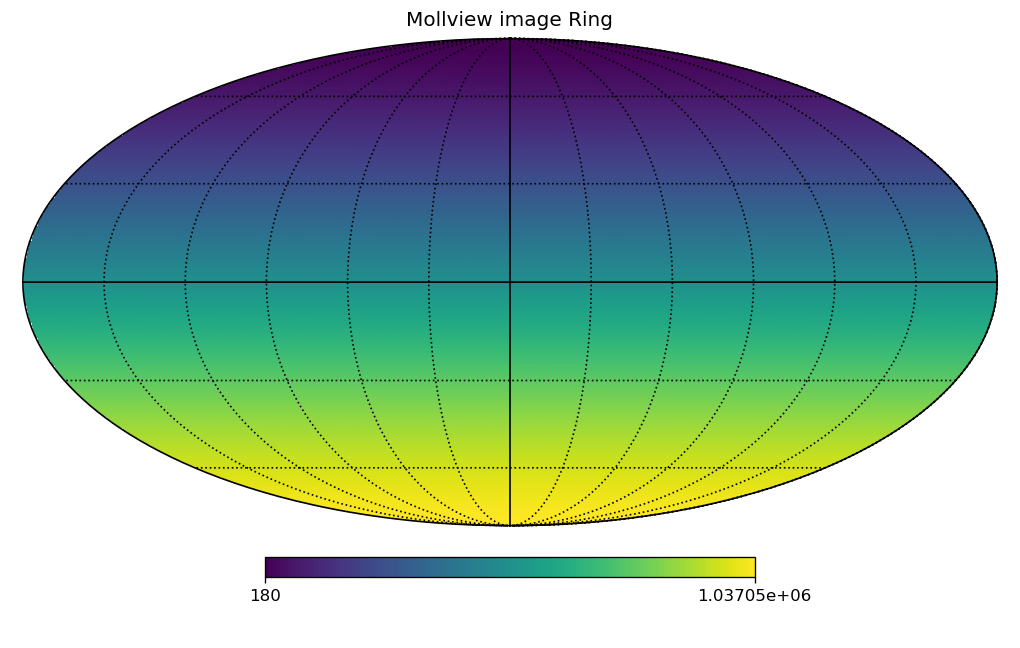

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/xavier/Projects/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/xavier/Projects/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


In [24]:
m = np.arange(npix_hp)
hp.mollview(m, title='Mollview image Ring')
hp.graticule()

## Angles (deg)

In [26]:
theta, phi = np.degrees(hp.pix2ang(nside=nside, ipix=np.arange(npix_hp))) #[0, 1, 2, 3, 4]))

In [29]:
theta.size

1037232

In [33]:
np.max(theta)

179.84087815269316

# Interpolate

## Mesh me

In [48]:
lat_mesh, lon_mesh = np.meshgrid(lat_coord, lon_coord, indexing='ij')

In [49]:
lat_mesh.shape

(720, 1440)

In [52]:
jan1_1990.shape

(720, 1440)

In [95]:
jan1_1990.fill_value = -10.
jan1_1990

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [-1.71999990940094, -1.71999990940094, -1.71999990940094, ...,
         -1.71999990940094, -1.71999990940094, -1.71999990940094],
        [-1.71999990940094, -1.71999990940094, -1.71999990940094, ...,
         -1.71999990940094, -1.71999990940094, -1.71999990940094],
        [-1.71999990940094, -1.71999990940094, -1.71999990940094, ...,
         -1.71999990940094, -1.71999990940094, -1.71999990940094]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-10.0,
  dtype=float32)

## Interpolate

In [96]:
func = interpolate.RectBivariateSpline(lat_coord, lon_coord, jan1_1990.filled(), kx=2, ky=2)#, epsilon=2)

In [97]:
new_SST = func.ev(90-theta, phi)

In [98]:
new_SST.shape

(1037232,)

## Plot

<IPython.core.display.Javascript object>


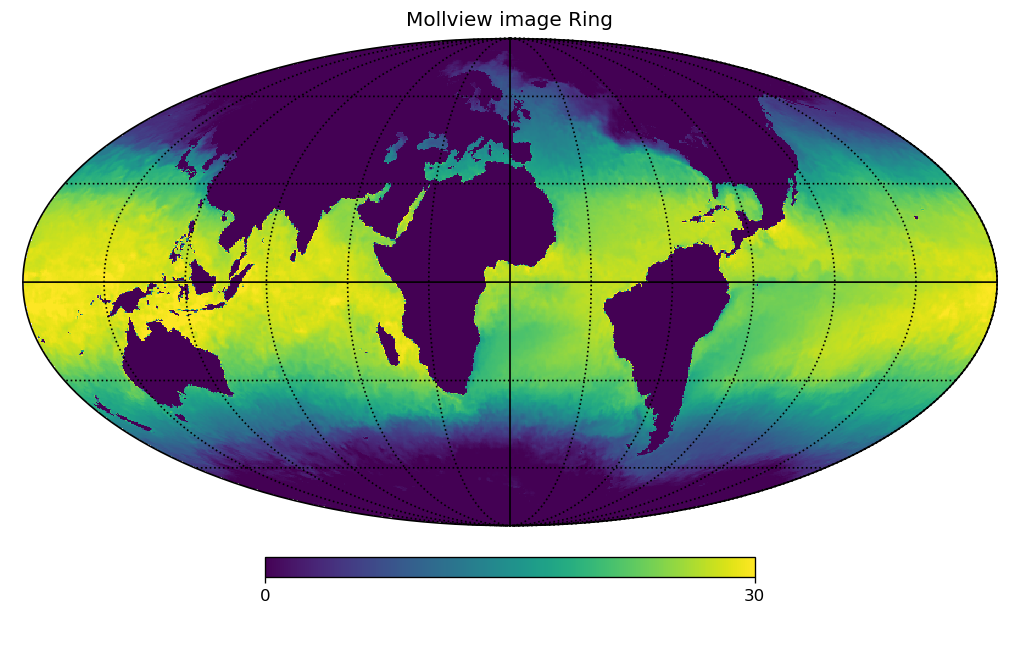

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [99]:
#m = np.arange(npix_hp)
hp.mollview(new_SST, title='Mollview image Ring', max=30., min=0.)
hp.graticule()

# Save

In [ ]:

    # Write
    t = Table()
    t['flux'] = DM_tot  # the data array
    t.meta['ORDERING'] = 'RING'
    t.meta['COORDSYS'] = 'G'
    t.meta['NSIDE'] = 1024
    t.meta['INDXSCHM'] = 'IMPLICIT'
    t.write(hp_file, overwrite=True)